# Parsing and analysing Incunabula catalogue entries

The BL holds over 12,500 copies of [Incunabula](https://www.bl.uk/collection-guides/early-printed-books) (books with movable type printed pre-1501). Details of these copies are contained in the British Museum Catalogues (BMC). These catalogues have been digitised, and this project works with vols 1 - 10 as data. Rossitza's fellowship focussed on extracting all the individual catalogue entries in each volume then using the combined dataset as material for corpus linguistics analysis. An ongoing goal is to match extracted entries to their shelfmarks and enrich existing records, which lack copy specific information. 

![image](https://www.bl.uk/britishlibrary/~/media/subjects%20images/classics/erotemata1495-800.jpg?w=624&h=351&hash=D4F3AD4F1F10B8F82A51B2988EC76292)
<center>Constantine Lascaris, Erotemata, with the Latin translation of Johannes Crastonus Placentinus. Venice: Aldus Manutius, 1495</center>


Text was extracted from the digitised volumes using two bespoke layout models and a text model on [Transkribus](lite.transkribus.com). This notebook demonstrates three steps in extracting text data from those xmls and turning them into accurate catalogue entries.

- Extract catalogue entries
- Find information about holdings of extra copies within entries
- Look at lengths of entries and understand if outliers have been correctly categorised

The notebook is a semi-guided tour through the functionality we have built. There are some tasks to complete to help you understand the process, and some explanation of the code. If you want to dig deeper into the code you can view the functions used here at `src/data/xml_extraction.py`

The folder structure for this binder is:
- notebooks  
   - Working with the British Museum Incunabula Catalogue.ipynb [this notebook]
- data
    - raw: all raw data needed
        - BMC_1_2_column_model_output
            - page: page xml files
            - jpgs of catalogue pages
        - BMC_1_4_column_model_output
            - page: page xml files
            - jpgs of catalogue pages
    - processed: where we'll store our results
- src [source]
    - Python code including the xml_extraction module Isaac and I have written

In [ ]:
import sys
if '../' not in sys.path:
    sys.path.append('../')
import glob
import os
import re
from xml.etree import ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from src.data import xml_extraction as xmle

## 1. Extracting catalogue entries from page xmls

Optical character recognition (OCR) was run on Transkribus using two layout models which learn *where* the text is on a scanned catalogue page, and one text model which learns how to map printed text to machine readable text. The two layout models catered for pages with two columns of text and pages with two columns split by full width text, giving four columns total. See below.  

Text(0.5, 0, 'Four column example')

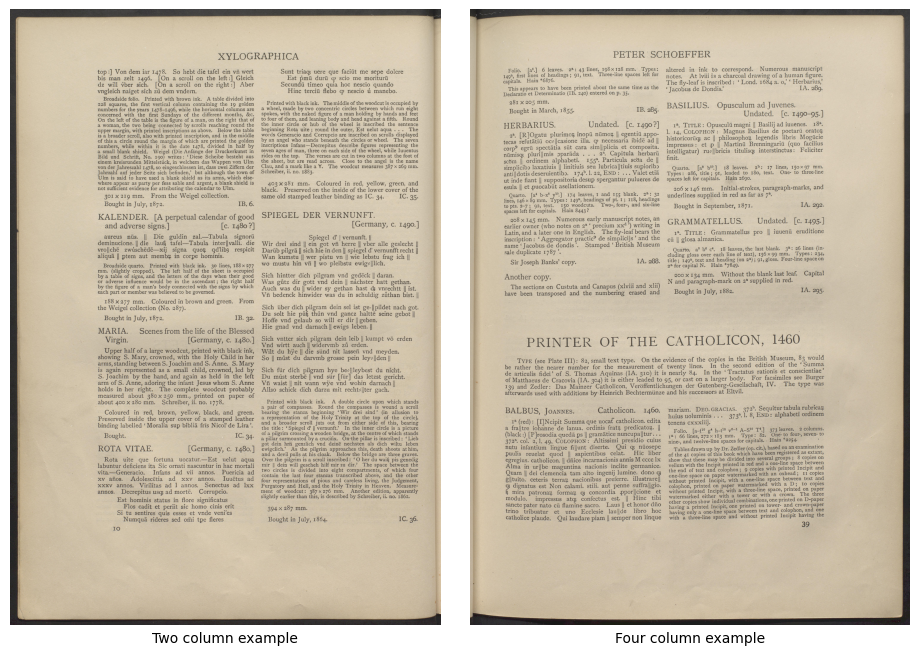

In [25]:
two_col_path = "../data/raw/BMC_1_2_column_model_output/0008_J_2704_aa_30_1_0045.jpg"
four_col_path = "../data/raw/BMC_1_4_column_model_output/0005_J_2704_aa_30_1_0074.jpg"

col_ims_fig, col_ims_ax = plt.subplots(1,2, figsize=(12,8),
                                       subplot_kw={"frame_on":False, "xticklabels":[], "yticklabels":[], "xticks":[], "yticks":[]},
                                       gridspec_kw={"wspace":0})
col_ims_ax[0].imshow(imread(two_col_path))
col_ims_ax[1].imshow(imread(four_col_path))
col_ims_ax[0].set_xlabel("Two column example")
col_ims_ax[1].set_xlabel("Four column example")

Once the layout models have run the text is transcribed by a text model. This output is available as page and alto xmls. Alto xmls contain location information for each line of text extracted, so a Southampton Uni intern (Isaac Dunford) initially tried to use this location information to extract entry headings, on the grounds that headings are surrounded by predictable whitespace. This proved difficult, so the second step was extracting text from the simpler page xmls and using language processing to extract catalogue entries from the combined page xml text.

In [ ]:
"""
The format of a Transkribus page xml file. The output here shows the first line of transcribed text.
The file contains the transcribed text in a TextRegion (aka 'column')/TextLine/Word structure.
The first column starts with the <TextRegion> tag on line 19.
The first line starts with the <TextLine> tag on 21 (and ends with </TextLine> on 111)
The first word is in the <Word></Word> tag on 24-29.
The output extract_lines_for_vol uses later on is actually the complete line, in the <TextEquiv></TextEquiv> tag on 108-110
There's a quirk with the reading order of this file, 10 points if you who can work it out.
"""
!head -n 111 ../data/raw/BMC_1_2_column_model_output/page/0007_J_2704_aa_30_1_0044.xml | cat -n

In [ ]:
two_col_loc = f"../data/raw/BMC_1_2_column_model_output/page"
four_col_loc = f"../data/raw/BMC_1_4_column_model_output/page"
# function to read all the xmls from these two locations
current_volume = xmle.gather_2_4_col_xmls(two_col_loc, four_col_loc)

Pages of the Incunabula are split between the 2 and 4 col sets, so we need to recombine, ensuring we've got the right page order. XML filenames are of the form XXXX_J_YYYY_ZZ_AA_B_CCCC.xml  

The page numbers that are consistent across 2 and 4 col sets are encoded in the **CCCC** part, so we can check what pages we have, then make sure the code in `gather_2_4_col_xmls` has correctly ordered them.

#### Task: Verify that the xml page order has been retained in the output of gather_2_4_col_xmls()

In [ ]:
print("Two col")
print(os.listdir("../data/raw/BMC_1_2_column_model_output/page"))

print("Four col")
print(os.listdir("../data/raw/BMC_1_4_column_model_output/page"))

In [ ]:
list(current_volume.keys())

The raw material we need is all the text lines from these xmls. `extract_lines_for_vol` will do this for us.

#### Task: Open J_2704_aa_30_1_0044_2.jpg and check that the first lines that have been extracted are the opening lines of this page.
#### Optional: what's the purpose of `xml_track_df`?

In [ ]:
lines, xml_track_df = xmle.extract_lines_for_vol(current_volume)
lines

`find_headings` contains all the logic for working out where catalogue entries start and end. It does this by finding the titles at the start of entries. `extract_catalogue_entries` then pulls all the text between one entry heading and the next to form that entry.

#### Task: Understand why the first entry starts where it does  
The logic in `find_headings` goes something like this (you're welcome to investigate the code in src/data/xml_extraction.py):
1. Iterate through all lines in `lines`
2. If a line matches the pattern (regular expression) for a shelfmark look at the next 8 lines.
3. If the 8 lines contain three succesive capital letters (titles should be all caps) and contains a date, then it's a valid title
4. Store the valid title, and skip on to the next line after the date found in step 3.
5. Continue until iterated through all `lines`

The shelfmark [regular expression](https://docs.python.org/3/howto/regex.html#regex-howto) is a pattern that the code searches through each line for. The pattern can be either of:
- I[ABC]\\.[ ]?[0-9]
    - I = I
    - [ABC] = any of A, B or C
    - \\. = a full stop
    - [ ]? = an optional space
    - [0-9] = any digit in 0-9
    - e.g. IC. 311
- [^A-Za-z0-9\\n\.\-\u201C]C\\.[ ]?[0-9]
    - [^A-Za-z0-9\\n\.\-\u201C] = none of upper/lower case A-Z, a digit, a new line, a full stop, a dash, or an odd "
    - C = C
    - \\. = full stop
    - [ ]? = an optional space
    - [0-9] =  any digit in 0-9
    - e.g. C.2445
    
The resulting entries are stored in `entry_df` (entry dataframe). This will display underneath the next cell when you run, and the entries are in the `entry_text` column.  The first entry is:

The first entry begins:
"Bought in 1852."  
"Kalender oder Tafel der,"  
"KALENDER."  
**Can you understand, looking at `lines`, why the first entry starts here?**

In [ ]:
title_shelfmarks, title_indices = xmle.find_headings(lines)
entry_df = xmle.extract_catalogue_entries(lines, title_indices, title_shelfmarks, xml_track_df)
entry_df

#### Optional discussion
- What are some examples of where the entry title detection not work so well?
- Why do not all the entries start with a capitalised title?
- Are there any examples where errors have occured because of the Transkribus transcription

## 2. Finding "Another Copy" information in entries

Entries often contain information about a work, then note that collection contains multiple copies of the same work. In some cases these are complete copies, in others just fragments. These separate copies mostly have their own shelfmarks and need to be catalogued separately, using the same bibliographic information but different copy specific information.  

The page below is a good example. There are "A cancelled copy of..." entries in the first column, and DURANTI at the end of the first column has "Another copy" a quarter of the way down the first column. The following code is all in development, so any examples you find that can be fed in to help improve detection will be helpful!

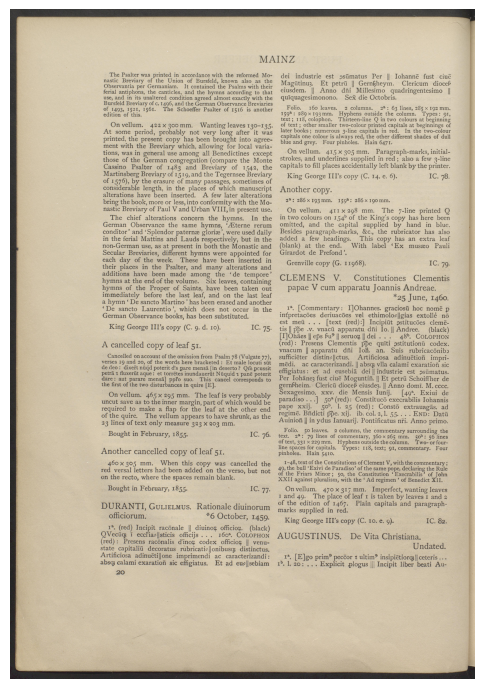

In [26]:
copy_fig, copy_ax = plt.subplots(figsize=(6,12), subplot_kw={"frame_on":False, "xticklabels":[], "yticklabels":[], "xticks":[], "yticks":[]})
copy_ax.imshow(imread("../data/raw/BMC_1_2_column_model_output/0011_J_2704_aa_30_1_0055.jpg"))

I've established all the "Another" patterns that actually mark extra copies we hold. These are in the `another_variants` list in `extract_another_copy`.

In [ ]:
def extract_another_copy(text: str) -> list:
    """
    Search for each of the variants of 'Another copy' in text and return any occurences
    :return: list
    """
    another_variants = [
        'Another cancelled',
        'A cancelled',
        'Another copy',
        'Another edition',
        'Another fragment,',
        'Another issue'
    ]
    
    match = []
    for v in another_variants:
        p = re.compile(v)
        m = p.finditer(text)
        if m:
            match += m
    
    if match:
        return match
    else:
        return None

In [ ]:
def check_for_leading_shelfmark(row: pd.DataFrame, match_col:str, find_valid: bool=True) -> list|None:
    """
    Search for a shelfmark in the 100 characters preceeding each incidence of one of the "Another copy" variants
    All extra copies should be preceeded by a shelfmark of the 'lead' copy (or possible a different "another copy")
    If the "another copy" is preceeded by a shelfmark save it as a valid copy, if not ignore it
    This function can be run in the inverse by setting find_valid=False so that invalid copies can also be saved
    This can act as a check that all copies have been seen by this function
    """
    shelfmark = False
    valid_matches = []
    
    if row[match_col]:
        valid = [xmle.find_title_shelfmark(row["entry_text"][match.span()[0]-100: match.span()[1]]) for match in row[match_col]]
        if not find_valid:
            valid = [not v for v in valid]
        valid_matches = [m for m, v in zip(row[match_col], valid) if v] 
    if valid_matches:
        return valid_matches
    else:
        return None

In [ ]:
entry_df["other_copies"] = entry_df["entry_text"].apply(lambda x: extract_another_copy(x))
entry_df["valid_copies"] = entry_df.apply(check_for_leading_shelfmark, match_col="other_copies", axis=1)
entry_df["invalid_copies"] = entry_df.apply(check_for_leading_shelfmark, match_col="other_copies", find_valid=False, axis=1)
entry_df.head()

We have an invalid match for another copy in the fourth entry, let's investigate.  
**Task: Why did the code not recognise this as a valid copy, and why is it not a valid copy in cataloguing terms?**  
You can check the jpg for further clarification, look to the `xml` column of entry_df for row 4, the string there is the jpg name with the last digit indicating whether it's in the 2 or 4 column folder in data\raw

In [ ]:
match_span = entry_df.loc[4, "invalid_copies"][0].span()
print("\n".join(entry_df.loc[4, "entry_text"][match_span[0]-200:match_span[1]+200].split("\n")[1:-1]))

#### Task: Investigate copies that the code has found and whether they've been correctly classified as valid or invalid
We need your help! This code isn't perfect and we need examples of where it's not working. 

Entries with 'valid' copies: 9, 11, 14, 15, 18, 26, 27, 29, 32, 33, 36, 37, 38, 40
Entries with 'invalid' copies: 4, 14, 22

Use the code below, replacing `idx` with one of the valid or invalid copy entry numbers above. If the copy has been classified correctly, great! If not please leave the copy number and a brief explanation as an issue [here](https://github.com/britishlibrary/Incunabula-Catalogue-Entry-Detection/issues) (click the green 'New issue' button top right).

If you want to look at the image for confirmation run the cell below with whatever entry number you're interested in.

In [ ]:
entry_number = 9
jpg, col_num = entry_df.loc[entry_number, "xml"][:-2] + ".jpg", entry_df.loc[entry_number, "xml"][-1]
image_path = glob.glob(f"../data/raw/BMC_1_{col_num}_column_model_output/*{jpg}")
!{image_path[0]}

##### Valid copies

In [ ]:
# 9, 11, 14, 15, 18, 26, 27, 29, 32, 33, 36, 37, 38, 40
idx = 9
for i, c in enumerate(entry_df.loc[idx, "valid_copies"]):
    print(f"Valid 'another copy' {i+1}\n")
    match_span = c.span()
    print("\n".join(entry_df.loc[idx, "entry_text"][match_span[0]-200:match_span[1]+200].split("\n")[1:-1]) + "\n")

##### Invalid copies

In [ ]:
# 4, 14, 22
idx = 4
for i, c in enumerate(entry_df.loc[idx, "invalid_copies"]):
    print(f"Invalid 'another copy' {i+1}\n")
    match_span = c.span()
    print("\n".join(entry_df.loc[idx, "entry_text"][match_span[0]-200:match_span[1]+200].split("\n")[1:-1]) + "\n")

## 3. Investigating entry length

Extracting the length of each entry is straightforward, and allows us to understand (assuming that we've got all the lengths right) whether entry length has changed over time. This is a big assumption though, as with nearly 9000 entries it's almost certain that we've made errors in entry extraction. The most obvious place to start is with the longest entries, and investigate whether these really represent long entries, or whether we've made a mistake.  

The combined output for all BMC volumes 1-10 is available on the research repository, which is where we'll read it from here.

In [ ]:
research_repository_url = "https://bl.iro.bl.uk/downloads/3acf5ba2-db4c-4cd8-96ce-66981a622e34?locale=en"
all_vol_entry_df = pd.read_csv(research_repository_url, index_col=0)
all_vol_entry_df["entry_length"] = all_vol_entry_df["entry_text"].transform(lambda x: len(x))

In [ ]:
all_vol_entry_df.head()

We can calculate the moving average entry length and the mean for each volume

In [ ]:
ma = all_vol_entry_df["entry_length"].rolling(window=100, center=True).mean()  # moving average of entry lengths
mean = all_vol_entry_df.groupby(by="vol")["entry_length"].mean()  # average of all entries in a volume

In [ ]:
# You don't need to parse all this plotting code.

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(all_vol_entry_df["entry_length"], lw=1)
ax.plot(ma, "black", label="Moving average")
ax.set_title("Catalogue Entry Length For Incunabula Volumes 1-10", fontsize='x-large')
ax.set_xlabel("Catalogue Entry Number (across all volumes)", fontsize='x-large')
ax.set_ylabel("Entry length (characters)", fontsize='x-large')
ax.tick_params(labelsize='large')

n_entrys = all_vol_entry_df.groupby(by="vol")["vol"].count()
n_entrys.loc[0] = 0
n_entrys.sort_index(inplace=True)
x_locs = n_entrys.cumsum() - n_entrys.cumsum().diff()/2

ax.vlines(n_entrys.cumsum(), 0, ax.get_ylim()[1], colors="black", linestyles="--")
ax.set_xlim(0, len(all_vol_entry_df))
ax.set_ylim(0, all_vol_entry_df["entry_length"].max() + 100)
for i, x in enumerate(x_locs.dropna()[:8]):
    ax.text(x, 10600, f"BMC {i+1}\n$\mu$: {mean.loc[i+1]:.0f}", ha="center")
    
ax.text(x_locs[9], 10600, f"BMC {9}", rotation="vertical", ha="center")
ax.text(x_locs[10], 10600, f"BMC {10}", rotation="vertical", ha="center")
ax.text(x_locs[9], 9100, f"$\mu$: {mean.loc[9]:.0f}", rotation="vertical", ha="center")
ax.text(x_locs[10], 9100, f"$\mu$: {mean.loc[10]:.0f}", rotation="vertical", ha="center")
ax.legend()

There are some very long entries here. Let's look at all entries > 5000 characters (~1000 words).

In [ ]:
print(f"\n{all_vol_entry_df.query('entry_length > 5000').shape[0]} entries longer than 5000 characters\n\n")
all_vol_entry_df.query("entry_length > 5000")

The long entries are:  
3,  6, 29, 42, 48, 63, 1302, 1394, 1421, 1442, 1861, 2420, 2926, 3063,  
3196, 3419, 3421, 3447, 3515, 3866, 4007, 4144, 4182, 4305, 4585, 4650,  
4725, 4726, 4835, 5678, 5694, 5699, 5700, 5801, 6235, 6433, 6934, 7008,  
7036, 7054, 7350, 7374, 7377, 7421, 7559, 7596, 7645, 7649, 7655, 7657,  
7664, 7671, 7688, 7734, 7812, 7939, 8026, 8064, 8065, 8115, 8133, 8134,  
8188, 8227, 8241, 8257, 8260, 8268, 8407, 8440, 8471

In [ ]:
long_idx = 3
print(all_vol_entry_df.loc[long_idx])
print("\n" + all_vol_entry_df.loc[long_idx, "entry_text"])

#### Task: Investigate very long entries
I haven't made all of the images for the long entries available on github as there are quite a lot of them. If we've made it this far in the time available and you don't have access to the Incunabula folder (\\\\ad\collections\TwoCenturies\TwoCenturies IV\Incunabula) let me know and we can discuss. If you do have access then use the xml column as before to guide you through the BMC_{Vol#} folders to find the correct jpg so you can view it and understand whether you are, in fact, looking at a very long entry or whether there's been an error in entry detection. As before, use the [github issues](https://github.com/britishlibrary/Incunabula-Catalogue-Entry-Detection/issues) page to note down any problem entries you find and what's wrong with them.

**The end**

Well done for making it to the end! The only part we haven't done is export the catalogue entries in a format that works for Antconc. If you've got questions about this let me know, but it's a fairly straightforward conversion to a .txt file.

Thanks for taking part!